In [1]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # for aesthetic

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
from importlib import reload
import tqdm
%matplotlib inline

sns.set_style('ticks')

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
winsize = 10.0
segment_info = [0, 0]
pover = 0.5
block_path = '/home/brad/krista/B1083/P03S03/'
#block_path = '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site05_Z3500__B1056_cat_P01_S05_1/'
#block_path = '/home/brad/krista/B1235/P02S01/'
# Bin data
bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=pover*winsize, comment='ForSCM')
bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print(bdf)

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20170829T191155Z-10.0-5.0.binned


In [3]:
thresh = 13.0


nperms=None
ncellsperm=0
dims = [0,1,2,3]
twin = np.linspace(0, 6000, 100)
windt = winsize
dtovr=pover*windt

stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}

In [4]:
reload(tp2)
# compute real and shuffled betti curves - TrialAverage
print('Computing trial average')
(bc_tavg, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr)
(bc_tavg_shuff, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl-Shuffle', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr, shuffle=True)

Computing trial average


In [ ]:
bc['I_40k'].shape

In [ ]:
reload(tp2)
with h5.File(bdf, 'r') as bdff:
    stims = bdff.keys()
    for stim in stims:
        print(stim)
        stim_poptens = tp2.extract_population_tensor(bdf, stim)
        ntrials = tp2.num_trials(stim_poptens)
        stim_scm_dat= []
        for trial in tqdm.tqdm(range(ntrials)):
            scm_bettis = tp2.calc_scm_betti_distribution(stim_poptens, thresh, trial, nsamples)
        
            stim_scm_dat.append(scm_bettis)
        stim_scm_dict[stim] = stim_scm_dat

In [5]:
def plot_scm_distribution(scm_bettis, trial, bettinum, ax=None, **kwargs):
    
    scm_trial_bettis = scm_bettis[trial]
    bettivals = []
    try:
        for x in scm_trial_bettis:
            try:
                bettivals.append(x[0][bettinum])
            except IndexError:
                bettivals.append(0)
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    bettivals2 = []
    for x in bettivals:
        if type(x) is not list:
            bettivals2.append(x)
        else:
            bettivals2.append(x[0])
    #print(bettivals)
    ax.hist(bettivals2, 20, normed=1, **kwargs)

In [6]:
# average over all trials
import tqdm
nsamples = 200

stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}
with h5.File(bdf, 'r') as bdff:
    stims = bdff.keys()
    for stim in tqdm.tqdm(stims):
        #print(stim)
        trial=0
        stim_poptens = tp2.extract_population_tensor(bdf, stim)
        ntrials = tp2.num_trials(stim_poptens)
        stim_scm_dat= []
        stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, :, np.newaxis]     
        scm_bettis = tp2.calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
        stim_scm_dict[stim] = scm_bettis


  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



1it [13:15, 795.61s/it]
2it [13:15, 557.04s/it]
3it [13:16, 390.05s/it]
4it [13:16, 273.18s/it]
5it [13:17, 191.34s/it]
6it [13:17, 134.06s/it]
7it [13:18, 93.96s/it] 
8it [13:18, 65.90s/it]
9it [13:18, 46.25s/it]
10it [13:19, 32.51s/it]
11it [13:19, 22.89s/it]
12it [13:20, 16.14s/it]
13it [13:20, 11.42s/it]
14it [13:21,  8.11s/it]
15it [13:21,  5.79s/it]
16it [13:21,  4.20s/it]
17it [13:22,  3.07s/it]
18it [13:22,  2.27s/it]
19it [13:23,  1.72s/it]
20it [13:23,  1.32s/it]
21it [13:23,  1.05s/it]
22it [13:24,  1.17it/s]
23it [13:24,  1.37it/s]
24it [13:25,  1.57it/s]
25it [13:25,  1.75it/s]
26it [13:26,  1.88it/s]
27it [13:26,  1.99it/s]
28it [13:26,  2.11it/s]
29it [13:27,  2.20it/s]
30it [13:27,  2.16it/s]
31it [13:28,  2.24it/s]
32it [13:28,  2.31it/s]
33it [13:28,  2.39it/s]
34it [13:29,  2.40it/s]
35it [13:29,  2.40it/s]
36it [13:30,  2.28it/s]
37it [13:30,  2.18it/s]
38it [13:31,  2.27it/s]
39it [13:31,  2.35it/s]
40it [13:32,  2.30it/s]
41it [13:32,  2.17it/s]
42it [13:33,  2.1

Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



1it [09:23, 563.94s/it]
2it [09:24, 394.80s/it]
3it [09:24, 276.40s/it]
4it [09:24, 193.52s/it]
5it [09:24, 135.50s/it]
6it [09:24, 94.89s/it] 
7it [09:24, 66.46s/it]
9it [09:24, 46.55s/it]
10it [09:24, 32.61s/it]
12it [09:25, 22.86s/it]
13it [09:25, 16.03s/it]
14it [09:25, 11.26s/it]
15it [09:25,  7.91s/it]
17it [09:25,  5.57s/it]
19it [09:25,  3.92s/it]
21it [09:26,  2.77s/it]
23it [09:26,  1.97s/it]
25it [09:26,  1.40s/it]
27it [09:26,  1.01s/it]
29it [09:26,  1.36it/s]
31it [09:26,  1.85it/s]
33it [09:27,  2.46it/s]
35it [09:27,  3.21it/s]
37it [09:27,  4.07it/s]
39it [09:27,  5.00it/s]
41it [09:27,  5.95it/s]
43it [09:28,  6.85it/s]
45it [09:28,  7.47it/s]
47it [09:28,  7.99it/s]
49it [09:28,  7.67it/s]
50it [09:28,  7.60it/s]
51it [09:29,  8.18it/s]
53it [09:29,  8.59it/s]
54it [09:29,  8.77it/s]
55it [09:29,  8.93it/s]
56it [09:29,  8.48it/s]
58it [09:29,  8.85it/s]
59it [09:29,  9.14it/s]
61it [09:30,  9.43it/s]
63it [09:30,  9.72it/s]
64it [09:30,  9.74it/s]
66it [09:30, 10.1

Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



1it [09:46, 586.33s/it]
2it [09:46, 410.49s/it]
3it [09:46, 287.39s/it]
4it [09:46, 201.23s/it]
5it [09:47, 140.92s/it]
6it [09:47, 98.71s/it] 
7it [09:47, 69.16s/it]
8it [09:47, 48.47s/it]
9it [09:47, 33.98s/it]
10it [09:48, 23.84s/it]
11it [09:48, 16.75s/it]
12it [09:48, 11.79s/it]
13it [09:48,  8.32s/it]
14it [09:48,  5.88s/it]
15it [09:49,  4.17s/it]
16it [09:49,  2.97s/it]
17it [09:49,  2.13s/it]
18it [09:49,  1.54s/it]
19it [09:49,  1.13s/it]
20it [09:49,  1.18it/s]
21it [09:50,  1.55it/s]
22it [09:50,  1.87it/s]
23it [09:50,  2.25it/s]
24it [09:50,  2.73it/s]
25it [09:50,  3.25it/s]
26it [09:51,  3.52it/s]
27it [09:51,  3.94it/s]
28it [09:51,  4.32it/s]
29it [09:51,  4.58it/s]
30it [09:51,  4.82it/s]
31it [09:52,  4.94it/s]
32it [09:52,  4.93it/s]
33it [09:52,  5.03it/s]
34it [09:52,  4.97it/s]
35it [09:52,  4.74it/s]
36it [09:53,  4.99it/s]
37it [09:53,  5.27it/s]
38it [09:53,  5.25it/s]
39it [09:53,  5.20it/s]
40it [09:53,  5.31it/s]
41it [09:54,  5.37it/s]
42it [09:54,  5.53

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [04:28, 268.34s/it]
2it [04:28, 187.92s/it]
3it [04:28, 131.63s/it]
4it [04:29, 92.23s/it] 
5it [04:29, 64.66s/it]
6it [04:29, 45.35s/it]
7it [04:30, 31.84s/it]
8it [04:30, 22.40s/it]
9it [04:30, 15.78s/it]
10it [04:31, 11.15s/it]
11it [04:31,  7.89s/it]
12it [04:31,  5.61s/it]
13it [04:32,  4.03s/it]
14it [04:32,  2.92s/it]
15it [04:32,  2.17s/it]
16it [04:33,  1.60s/it]
17it [04:33,  1.21s/it]
18it [04:33,  1.06it/s]
19it [04:34,  1.34it/s]
20it [04:34,  1.63it/s]
21it [04:34,  1.93it/s]
22it [04:34,  2.19it/s]
23it [04:35,  2.44it/s]
24it [04:35,  2.67it/s]
25it [04:35,  2.84it/s]
26it [04:36,  2.99it/s]
27it [04:36,  3.04it/s]
28it [04:36,  3.17it/s]
29it [04:37,  3.14it/s]
30it [04:37,  3.12it/s]
31it [04:37,  3.16it/s]
32it [04:38,  3.18it/s]
33it [04:38,  3.20it/s]
34it [04:38,  3.16it/s]
35it [04:38,  3.21it/s]
36it [04:39,  3.00it/s]
37it [04:39,  3.17it/s]
38it [04:39,  3.27it/s]
39it [04:40,  3.32it/s]
40it [04:40,  3.40it/s]
41it [04:40,  3.33it/s]
42it [04:41,  3.22it

Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None



1it [12:04, 724.97s/it]
2it [12:05, 507.53s/it]
3it [12:05, 355.31s/it]
4it [12:05, 248.76s/it]
5it [12:05, 174.17s/it]
6it [12:05, 121.96s/it]
7it [12:05, 85.42s/it] 
8it [12:05, 59.84s/it]
9it [12:06, 41.93s/it]
10it [12:06, 29.40s/it]
11it [12:06, 20.63s/it]
12it [12:06, 14.48s/it]
13it [12:06, 10.18s/it]
14it [12:06,  7.18s/it]
15it [12:07,  5.06s/it]
16it [12:07,  3.59s/it]
17it [12:07,  2.56s/it]
18it [12:07,  1.83s/it]
19it [12:07,  1.33s/it]
20it [12:07,  1.03it/s]
21it [12:07,  1.38it/s]
22it [12:08,  1.82it/s]
23it [12:08,  2.31it/s]
24it [12:08,  2.87it/s]
25it [12:08,  3.48it/s]
26it [12:08,  3.96it/s]
27it [12:08,  4.44it/s]
28it [12:08,  5.04it/s]
29it [12:09,  5.57it/s]
30it [12:09,  5.97it/s]
31it [12:09,  6.41it/s]
32it [12:09,  6.40it/s]
33it [12:09,  6.68it/s]
34it [12:09,  6.93it/s]
35it [12:09,  6.78it/s]
36it [12:10,  6.72it/s]
37it [12:10,  6.84it/s]
38it [12:10,  6.65it/s]
39it [12:10,  6.61it/s]
40it [12:10,  6.82it/s]
41it [12:10,  6.65it/s]
42it [12:11,  6.7

Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None



1it [12:49, 769.53s/it]
2it [12:49, 538.76s/it]
3it [12:50, 377.23s/it]
4it [12:50, 264.16s/it]
5it [12:50, 185.01s/it]
6it [12:51, 129.62s/it]
7it [12:51, 90.84s/it] 
8it [12:51, 63.68s/it]
9it [12:52, 44.67s/it]
10it [12:52, 31.37s/it]
11it [12:52, 22.06s/it]
12it [12:53, 15.53s/it]
13it [12:53, 10.98s/it]
14it [12:53,  7.79s/it]
15it [12:54,  5.56s/it]
16it [12:54,  4.01s/it]
17it [12:54,  2.92s/it]
18it [12:55,  2.15s/it]
19it [12:55,  1.61s/it]
20it [12:56,  1.24s/it]
21it [12:56,  1.04it/s]
22it [12:56,  1.26it/s]
23it [12:57,  1.53it/s]
24it [12:57,  1.80it/s]
25it [12:57,  2.03it/s]
26it [12:58,  2.27it/s]
27it [12:58,  2.49it/s]
28it [12:58,  2.63it/s]
29it [12:59,  2.67it/s]
30it [12:59,  2.84it/s]
31it [12:59,  2.94it/s]
32it [12:59,  3.06it/s]
33it [13:00,  3.00it/s]
34it [13:00,  2.95it/s]
35it [13:00,  2.99it/s]
36it [13:01,  2.91it/s]
37it [13:01,  2.88it/s]
38it [13:02,  2.91it/s]
39it [13:02,  2.87it/s]
40it [13:02,  2.82it/s]
41it [13:03,  2.86it/s]
42it [13:03,  2.9

Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None



1it [06:00, 360.87s/it]
6it [06:00, 252.62s/it]
11it [06:01, 176.84s/it]
16it [06:01, 123.79s/it]
21it [06:01, 86.66s/it] 
26it [06:01, 60.67s/it]
31it [06:01, 42.47s/it]
36it [06:01, 29.74s/it]
41it [06:01, 20.82s/it]
46it [06:01, 14.58s/it]
51it [06:01, 10.21s/it]
56it [06:02,  7.16s/it]
61it [06:02,  5.02s/it]
67it [06:02,  3.52s/it]
72it [06:02,  2.47s/it]
77it [06:02,  1.73s/it]
82it [06:02,  1.22s/it]
87it [06:02,  1.16it/s]
92it [06:02,  1.64it/s]
97it [06:02,  2.31it/s]
102it [06:02,  3.24it/s]
107it [06:03,  4.50it/s]
112it [06:03,  6.17it/s]
117it [06:03,  8.34it/s]
122it [06:03, 11.06it/s]
127it [06:03, 14.31it/s]
132it [06:03, 18.08it/s]
137it [06:03, 22.16it/s]
142it [06:03, 26.41it/s]
147it [06:03, 30.25it/s]
152it [06:04, 34.12it/s]
157it [06:04, 37.02it/s]
162it [06:04, 39.39it/s]
167it [06:04, 41.36it/s]
172it [06:04, 42.54it/s]
177it [06:04, 42.60it/s]
182it [06:04, 43.40it/s]
187it [06:04, 44.31it/s]
192it [06:04, 44.47it/s]
197it [06:05, 44.81it/s]
 88%|████████▊ |

Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None



1it [06:25, 385.22s/it]
4it [06:25, 269.67s/it]
7it [06:25, 188.78s/it]
10it [06:25, 132.16s/it]
13it [06:25, 92.52s/it] 
16it [06:25, 64.78s/it]
19it [06:25, 45.35s/it]
22it [06:25, 31.76s/it]
25it [06:26, 22.24s/it]
28it [06:26, 15.58s/it]
31it [06:26, 10.92s/it]
34it [06:26,  7.65s/it]
37it [06:26,  5.37s/it]
40it [06:26,  3.77s/it]
43it [06:26,  2.65s/it]
46it [06:26,  1.87s/it]
49it [06:27,  1.32s/it]
52it [06:27,  1.07it/s]
55it [06:27,  1.50it/s]
58it [06:27,  2.10it/s]
61it [06:27,  2.90it/s]
64it [06:27,  3.96it/s]
67it [06:27,  5.32it/s]
70it [06:27,  7.02it/s]
73it [06:27,  9.08it/s]
76it [06:28, 11.23it/s]
79it [06:28, 13.56it/s]
82it [06:28, 15.88it/s]
85it [06:28, 18.01it/s]
88it [06:28, 20.04it/s]
91it [06:28, 21.68it/s]
94it [06:28, 22.88it/s]
97it [06:28, 24.43it/s]
100it [06:28, 25.32it/s]
103it [06:29, 26.47it/s]
106it [06:29, 26.70it/s]
109it [06:29, 26.86it/s]
112it [06:29, 27.66it/s]
115it [06:29, 27.57it/s]
118it [06:29, 27.76it/s]
121it [06:29, 27.07it/s]
124it

In [7]:
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg_thresh13.pkl'), 'wb') as f:
    pickle.dump(stim_scm_dict, f)

In [38]:
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg.pkl'), 'rb') as f:
    stim_scm_dict = pickle.load(f)
stim_scm_dict

{'I_40k': array([[ array([   2.,   63.,  135.,    2.,    0.,    0.,    0.,    0.,    0.,    0.])],
        [ array([   2.,   62.,  140.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
        [ array([   2.,   69.,  152.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
        [ array([   2.,   56.,  172.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
        [list([-1, [-1]])],
        [ array([   2.,   56.,  171.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
        [ array([   2.,   56.,  176.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
        [ array([   2.,   50.,  193.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
        [ array([   2.,   51.,  187.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
        [ array([   2.,   65.,  160.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
        [ array([   2.,   58.,  183.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
        [ array([   2.,   56.,  194.,    0.,    0.,    0.,    0

In [19]:
int([-1])

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

[  2.  50.  72.   4.]
[  2.  58.  41.   3.]
[  3.  42.  42.   0.]


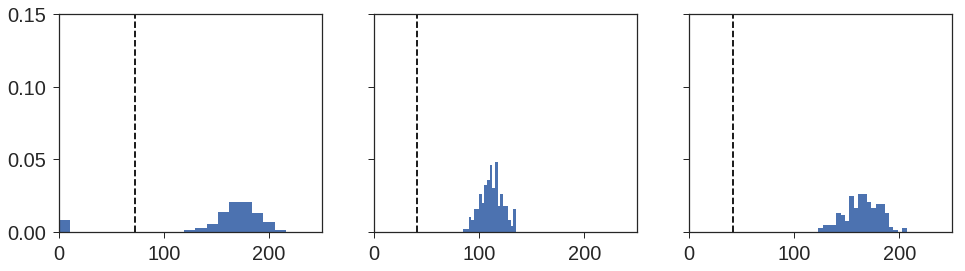

In [22]:
f, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
betti_num = 2
stims = list(bc_tavg.keys())[1:4]
my = 0
for ax, stim in zip(axs.flatten(), bc_tavg.keys()):
    final_bettis = bc_tavg[stim][:, -1, 0]
   
    #final_bettis = stim_betticurve_dict[stim][-1]
    b = final_bettis[betti_num]
    ax.plot([b, b], [0, 100], 'k--')
    plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax)
    print(final_bettis)

    #ax.set_title(stim)
    
    ax.set_xlim([0, 250])
    ax.set_ylim([0, 0.15])
    ax.tick_params(labelsize=20)
plt.savefig(os.path.join('/home/brad/DailyLog/20170901/', 'SCMControlB1083_betti{}.eps'.format(betti_num)))

In [ ]:
#compute pvalues
dims2 = [0,1,2]
for stim in bc_tavg.keys():
    for dim in dims2:
        final_betti = bc_tavg[stim][dim, -1, 0]
        scm_dist = np.array(stim_scm_dict[stim])
        scm_dist = [x[0][dim] for x in scm_dist]
        m = np.mean(scm_dist)
        N = len(scm_dist)
        if final_betti > m:
        
            count = np.sum(np.greater(scm_dist, final_betti))
        else:
            count = np.sum(np.less(scm_dist, final_betti))
        p = 2*(1+count)/(N+1)
        print('Stim: {} dim: {}  pvalue: {}'.format(stim, dim, p))
    print('\n')
    

In [ ]:
np.mean(stim_scm_dict[stim][:, :, 1])

In [50]:
stim_scm_dict[stim]

array([[ array([   2.,   63.,  135.,    2.,    0.,    0.,    0.,    0.,    0.,    0.])],
       [ array([   2.,   62.,  140.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
       [ array([   2.,   69.,  152.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
       [ array([   2.,   56.,  172.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
       [list([-1, [-1]])],
       [ array([   2.,   56.,  171.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
       [ array([   2.,   56.,  176.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
       [ array([   2.,   50.,  193.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
       [ array([   2.,   51.,  187.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
       [ array([   2.,   65.,  160.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
       [ array([   2.,   58.,  183.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])],
       [ array([   2.,   56.,  194.,    0.,    0.,    0.,    0.,    0.,    0.,    0

In [ ]:
np.array(stim_scm_dict[stim]).shape

In [ ]:
test = stim_scm_dict[stim]


In [ ]:
test

In [19]:
with h5.File(bdf, 'r') as f:
    test_pt = np.array(f[list(f.keys())[1]]['pop_tens'])

In [20]:
test_pt.shape

(101, 1200, 20)

In [13]:
trialavg = np.mean(test_pt, axis=2)

In [15]:
avg_frs = np.mean(trialavg, axis=1)

In [17]:
avg_frs.shape

(102,)

In [21]:
avg_frs

array([  1.71250000e+00,   2.75000000e-01,   1.11666667e+00,
         1.69916667e+01,   2.60833333e+00,   2.58333333e-01,
         6.76666667e+00,   8.33333333e-01,   2.03333333e+00,
         1.54166667e+00,   3.48750000e+00,   2.58333333e-01,
         6.77916667e+00,   5.42500000e+00,   3.99166667e+00,
         1.81666667e+00,   1.75000000e-01,   2.91666667e-01,
         4.75000000e-01,   2.21666667e+00,   1.50833333e+00,
         6.98333333e+00,   3.26250000e+00,   2.64166667e+00,
         3.16666667e-01,   2.54166667e+00,   5.08333333e-01,
         9.08333333e-01,   4.00000000e-01,   8.33333333e-03,
         9.66666667e-01,   1.06666667e+00,   8.50000000e-01,
         1.66666667e-02,   4.34166667e+00,   3.93333333e+00,
         5.16666667e+00,   5.41666667e-01,   1.33333333e-01,
         2.16666667e-01,   4.35000000e+00,   1.75833333e+00,
         7.04166667e+00,   4.04166667e+00,   8.06250000e+00,
         5.00000000e-02,   3.00000000e-01,   2.15833333e+00,
         2.33750000e+00,

array([ 5.,  0.,  0., ...,  0.,  5.,  5.])